# Support Vector Machine
### Optimization question for solving weight vector
\begin{equation*}
minimize\;\;\;f(\mathbf{w}) = \frac{1}{2} ||\mathbf{w}||^2 \\
subject \: to\;\;\;g_i(w_i, b) = y_i(w_i \mathbf{x}_i + b) - 1 \geq 0
\end{equation*}
### which can be transformed as a dual problem of lagrange formulation - wolfe dual problem
\begin{equation*}
L(\mathbf{w}, b, \lambda) = \frac{1}{2} ||\mathbf{w}||^2 - \sum_{i=1}^{m}\lambda_i[y_i(w_i \mathbf{x}_i + b) - 1]\\
\frac{\partial L(\mathbf{w}, b, \lambda)}{\partial \mathbf{w}} = \mathbf{w} - \sum_{i=1}^m{\lambda_{i}y_{i}\mathbf{x_i}} =0 \\
\frac{\partial L(\mathbf{w}, b, \lambda)}{\partial b} = \sum_{i=1}^{m}{\lambda_{i}y_{i}} = 0\\
subject \: to\;\;\;\lambda_i \geq 0
\end{equation*}
### can be simplified as:
\begin{equation*}
minimize\;\;\;W(\lambda) = \frac{1}{2} \sum_{i=1}^m \sum_{j=1}^m \lambda_i\lambda_{j}y_{i}y_{j}\mathbf{x}_{i}\mathbf{x}_{j} - \sum_{i = 1}^m \lambda_{i}\\
subject \: to\;\;\;\lambda_i \geq 0 \;\; and \;
\sum_{i=1}^{m}{\lambda_{i}y_{i}} = 0\
\end{equation*}
### KKT condition of complementary slackness has not been addressed in wolfe dual problem:
\begin{equation*}
\lambda_{i}[y_i(w_i \mathbf{x}_i + b) - 1]=0\\
since:\\ \: condition \: only \: based \: on \: support \: vectors\\
therefore:\\ y_i(w_i \mathbf{x}_i + b) - 1 = 0 \\
\lambda_{i} > 0
\end{equation*}
### matrix form of simplified wolfe problem:
\begin{equation*}
minimize\;\;\;W(\lambda)=\frac{1}{2}\mathbf{\lambda}^{T}(\mathbf{y}\mathbf{y}^{T}\mathbf{K})\mathbf{\lambda} - \mathbf{1}^T \mathbf{\lambda}\\
subject\:to\;\;\;-\lambda \leq 0\\
\mathbf{y}\lambda=0 \\
\mathbf{K} = \begin{vmatrix}
\mathbf{x_1}\mathbf{x_1} & \mathbf{x_1}\mathbf{x_2} &...& \mathbf{x_1}\mathbf{x_m} \\
\mathbf{x_2}\mathbf{x_1} & \mathbf{x_2}\mathbf{x_2} &...& \mathbf{x_2}\mathbf{x_m} \\
... & ... & ... & ... \\
\mathbf{x_m}\mathbf{x_1} & \mathbf{x_m}\mathbf{x_2} &...& \mathbf{x_m}\mathbf{x_m} \\
\end{vmatrix}
\end{equation*}

### cvxopt solver for quadratic programming has a standard input form of:
\begin{equation*}
minimize \;\;\; \frac{1}{2}x^T P x + q^T x\\
subject\;to \;\;\; G x \leq h\\
A x = b
\end{equation*}

In [215]:
import numpy as np


class svm:
    
    def __init__(self, X, y, C, verbose=False):
        self.X = X
        self.y = y
        self.verbose = verbose

        try:
            from cvxopt import matrix, solvers
            self._mtx = matrix
            self._qp  = solvers.qp
        except ImportError:
            raise ImportError("""
            The python module cvxopt is required to use
            quadratic programming functionality.
            Please use below command to safely install
            sudo conda install -c conda-forge cvxopt
            """)

        if not self.verbose:
            solvers.options['show_progress'] = False 
            
            
    def possible_inner_product(self, X):
        """
        find all possible inner products of a matrix and itself
        """
        
        m = X.shape[0]
        K = np.array([np.dot(X[i],X[j]) 
                      for i in range(m) 
                      for j in range(m)]).reshape((m,m))
        return K, m


    def wolfe_solver(self, X, y):
        """
        wolfe optimization problem is a dual form of lagrange,
        which is quadratic programming and solved by cvxopt
        """
        
        K, m = self.possible_inner_product(X)
        P = self._mtx(np.outer(y,y) * K, tc = 'd')
        q = self._mtx(-1 * np.ones(m))

        G = self._mtx(np.diag(-1 * np.ones(m)))
        h = self._mtx(np.zeros(m))

        A = self._mtx(y, size = (1,m), tc = 'd')
        b = self._mtx(0.0)

        solution = self._qp(P=P, q=q, G=G, h=h, A=A, b=b)
        
        return np.ravel(solution["x"])

    
    def find_support_vec(self):
        """
        find vector that has nonpositive lagrange multiplyers
        """
        
        multipliers = self.wolfe_solver(self.X, self.y)
        positive_pos = multipliers > 1e-7
        return self.X[positive_pos], self.y[positive_pos], multipliers[positive_pos]


    def direction(self, x):
        """
        function for calculation of directory vector
        direction vector is a unit vector with norm equals 1
        """
        
        return x / np.linalg.norm(x)

    
    def compute_weight(self):
        """
        compute weights and intercept based on only support vectors
        """
        
        X, y, multipliers = self.find_support_vec()
        w = np.dot(np.multiply(multipliers, y), X)
        b = np.dot(np.transpose(y), np.dot(X, w))
        return w, b
    
    def predict(self):
        """
        predict classification results
        """
        w, b = self.compute_weight()
        y_hat = np.dot(w, self.X) + b - 1
        return np.sign(y_hat) 
    


## Model test 
sklearn breast cancer dataset

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html

In [170]:
import sklearn.datasets as datasets
import pandas as pd

cancer_dat = datasets.load_breast_cancer()
cancer_dt = pd.DataFrame(cancer_dat.data, columns = cancer_dat.feature_names)

In [178]:
print(cancer_dt.shape)
cancer_dt.head()

(569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [207]:
print(cancer_dt.columns)
from collections import Counter
print(Counter(cancer_dat.target))

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')
Counter({1: 357, 0: 212})


In [191]:
mean_measures  = cancer_dt.iloc[:,['mean' in str for str in cancer_dt.columns]]
error_measures = cancer_dt.iloc[:,['erorr' in str for str in cancer_dt.columns]]
worst_measures = cancer_dt.iloc[:,['worst' in str for str in cancer_dt.columns]]

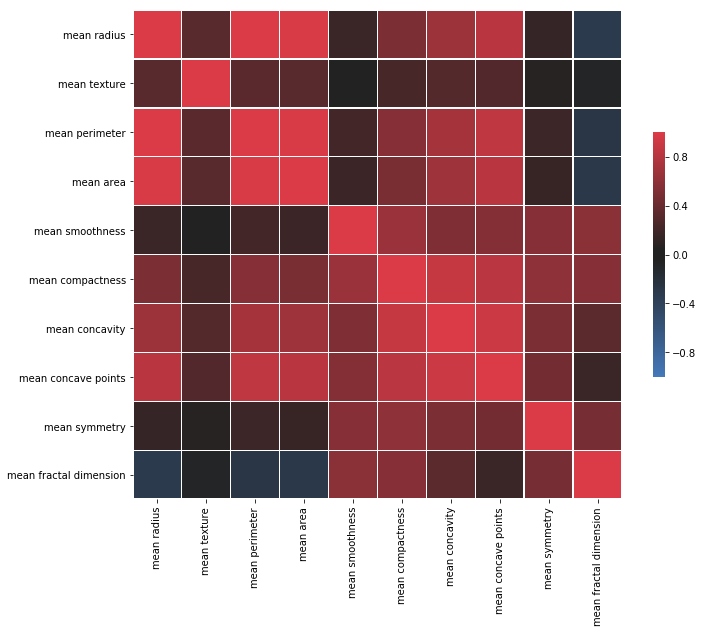

In [200]:
# plot variance-covariance matrix
import matplotlib.pyplot as plt
import seaborn as sns

mean_measures_corr = mean_measures.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True, center="dark")

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(mean_measures_corr, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

observe a strong correlation among mean radius, mean perimeter, and mean area

In [211]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(cancer_dat.data, cancer_dat.target, test_size = 0.20, 
                                                   stratify = cancer_dat.target, random_state = 20)
print("training data set shape is ", x_train.shape)
print("testing data set shape is", x_test.shape)

training data set shape is  (455, 30)
testing data set shape is (114, 30)


In [212]:
import numpy as np
w = np.array([0.4, 1])
b = -10
x = np.array([6, 8])
y = -1

def constraint(w, b, x, y): 
    return y * (np.dot(w, x) + b)

def hard_constraint_is_satisfied(w, b, x, y): 
    return constraint(w, b, x, y) >= 1

def soft_constraint_is_satisfied(w, b, x, y, zeta): 
    return constraint(w, b, x, y) >= 1 - zeta


In [213]:
# While the constraint is not satisfied for the example (6,8). 
print(hard_constraint_is_satisfied(w, b, x, y)) # False
# We can use zeta = 2 and satisfy the soft constraint. 
print(soft_constraint_is_satisfied(w, b, x, y, zeta=2))

False
True


In [218]:
# test transformation
def transformation(x):
    return x[0]**2, np.sqrt(2)*x[0]*x[1], x[1]**2

x1 = [3,6]
x2 = [10,10]

x1_3d = transformation(x1)
x2_3d = transformation(x2)
print(np.dot(x1_3d, x2_3d))

8100.0


## Kernel function

### Kernel express a meansure of similarity between two vecters

### Polynomial kernel function with n digree of order and constant c:

The similarity here is scaled angle between two vecters

\begin{equation*}
K_{poly} = \left[<x, x'> + c\right]^n
\end{equation*}

### Radial Basis Function (RBF) kernel with spread of gamma:

Calculates the inner product between two vectors that has been projected into a space of inifite dimensionality. The similarity in RBF kernel is the L2-norm of their distance. As the vector close to each other, the L2-norm gets smaller. Then, so long as gamma greater than zero, it follows that kernel will larger while vectors closer. This kernel function is of form of a bell-shape curve. Therefore, it is also called Gaussian kernel function

\begin{equation*}
K_{RBF}(x, x') = e^{-\gamma||x - x'||^2} \\
= e^{-\gamma(||x||^2 + ||x'||^2 - 2<x, x'>)} \\
= C e^{-2 \gamma <x, x'>}\;\;\;\;where\; C = e^{-\gamma(||x||^2 + ||x'||^2)}\\
= C \times \gamma \sum_{n=0}^\infty \frac{<x, x'>^n}{n!} \\
= C \times  \gamma \sum_{n=0}^\infty \frac{K_{poly}(x, x')}{n!}
\end{equation*}

It is a infinite sum over polynmomial kernel with constant zero

### Kernel function summation

\begin{equation*}
K_c(x,x') = K_a(x, x') + k_b(x,x')
\end{equation*}

The inner products of vectors in summed vector space:

\begin{equation*}
<\phi_c(x),\phi_c(x')>\; := \;<\phi_a(x),\phi_a(x')> + <\phi_b(x),\phi_b(x')>\\
:= \sum_{i}^{n_a}\phi_a(x)\phi_a(x')+\sum_{i}^{n_b}\phi_b(x)\phi_b(x')\\
:= \sum_{i}^{n_a+n_b}\phi_c(x)\phi_c(x')
\end{equation*}

since RBF is infinite sum of polynomical kernels with different orders, the dimensionality of RBF is infinity

In [251]:
def poly_kernel(x1, x2, degree, constant=0):
    """
    This is polynomial kernel function
    
    :param x1: input vector 1.
    :param x2: input vector 2.
    :param degree: integer, defines the degree of polynomial order.
    :param constant: numeric, defines the constant that adds onto the 
                     inner product of input vecoters.
    """
    x1 = np.array(x1)
    x2 = np.array(x2)
    return(pow(np.dot(x1, x2.T) + constant, degree))


def rbf_kernel(x1, x2, gamma):
    """
    This is radial basis kernel function or gaussian kernel function
    
    :param x1: input vector 1.
    :param x2: input vector 2.
    :param gamma: controls how the distribution of inner products spreads, 
                  a larger gamma has a narrow bell shape. A larger gamma
                  tends to overfit.
    """
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.exp(-gamma * np.linalg.norm(x1 - x2)**2)


def string_kernel(x1, x2):
    return



In [252]:
rbf_kernel(x1, x2, gamma = 0.01)

0.522045776761016

In [253]:
poly_kernel(x1, x2, degree = 3)

729000

In [ ]:
from random import randrange


# Written based on the pseudo-code in :
# http://luthuli.cs.uiuc.edu/~daf/courses/optimization/Papers/smoTR.pdf
class SmoAlgorithm:
    def __init__(self, X, y, C, tol, kernel, use_linear_optim):
        self.X = X
        self.y = y
        self.m, self.n = np.shape(self.X)
        self.alphas = np.zeros(self.m)

        self.kernel = kernel
        self.C = C
        self.tol = tol

        self.errors = np.zeros(self.m)
        self.eps = 1e-3  # epsilon

        self.b = 0

        self.w = np.zeros(self.n)
        self.use_linear_optim = use_linear_optim

    # Compute the SVM output for example i
    def output(self, i):
        if self.use_linear_optim:
            # Equation 1
            return float(np.dot(self.w.T, self.X[i])) - self.b
        else:
            # Equation 10
            return np.sum([self.alphas[j] * self.y[j]
                           * self.kernel(self.X[j], self.X[i])
                           for j in range(self.m)]) - self.b

    # Try to solve the problem analytically.
    def take_step(self, i1, i2):

        if i1 == i2:
            return False

        a1 = self.alphas[i1]
        y1 = self.y[i1]
        X1 = self.X[i1]
        E1 = self.get_error(i1)

        s = y1 * self.y2

        # Compute the bounds of the new alpha2.
        if y1 != self.y2:
            # Equation 13
            L = max(0, self.a2 - a1)
            H = min(self.C, self.C + self.a2 - a1)
        else:
            # Equation 14
            L = max(0, self.a2 + a1 - self.C)
            H = min(self.C, self.a2 + a1)

        if L == H:
            return False

        k11 = self.kernel(X1, X1)
        k12 = self.kernel(X1, self.X[i2])
        k22 = self.kernel(self.X[i2], self.X[i2])

        # Compute the second derivative of the
        # objective function along the diagonal.
        # Equation 15
        eta = k11 + k22 - 2 * k12

        if eta > 0:
            # Equation 16
            a2_new = self.a2 + self.y2 * (E1 - self.E2) / eta

            # Clip the new alpha so that is stays at the end of the line.
            # Equation 17
            if a2_new < L:
                a2_new = L
            elif a2_new > H:
                a2_new = H
        else:
            # Under unusual cicumstances, eta will not be positive.
            # Equation 19
            f1 = y1 * (E1 + self.b) - a1 * k11 - s * self.a2 * k12
            f2 = self.y2 * (self.E2 + self.b) - s * a1 * k12 \
                 - self.a2 * k22
            L1 = a1 + s(self.a2 - L)
            H1 = a1 + s * (self.a2 - H)
            Lobj = L1 * f1 + L * f2 + 0.5 * (L1 ** 2) * k11 \
                   + 0.5 * (L ** 2) * k22 + s * L * L1 * k12
            Hobj = H1 * f1 + H * f2 + 0.5 * (H1 ** 2) * k11 \
                   + 0.5 * (H ** 2) * k22 + s * H * H1 * k12

            if Lobj < Hobj - self.eps:
                a2_new = L
            elif Lobj > Hobj + self.eps:
                a2_new = H
            else:
                a2_new = self.a2

        # If alpha2 did not change enough the algorithm
        # returns without updating the multipliers.
        if abs(a2_new - self.a2) < self.eps * (a2_new + self.a2 \
                                                       + self.eps):
            return False

        # Equation 18
        a1_new = a1 + s * (self.a2 - a2_new)

        new_b = self.compute_b(E1, a1, a1_new, a2_new, k11, k12, k22, y1)

        delta_b = new_b - self.b

        self.b = new_b

        # Equation 22
        if self.use_linear_optim:
            self.w = self.w + y1 * (a1_new - a1) * X1 \
                     + self.y2 * (a2_new - self.a2) * self.X2

        # Update the error cache using the new Lagrange multipliers.
        delta1 = y1 * (a1_new - a1)
        delta2 = self.y2 * (a2_new - self.a2)

        # Update the error cache.
        for i in range(self.m):
            if 0 < self.alphas[i] < self.C:
                self.errors[i] += delta1 * self.kernel(X1, self.X[i]) + \
                                  delta2 * self.kernel(self.X2, self.X[i]) \
                                  - delta_b

        self.errors[i1] = 0
        self.errors[i2] = 0

        self.alphas[i1] = a1_new
        self.alphas[i2] = a2_new

        return True

    def compute_b(self, E1, a1, a1_new, a2_new, k11, k12, k22, y1):
        # Equation 20
        b1 = E1 + y1 * (a1_new - a1) * k11 + \
             self.y2 * (a2_new - self.a2) * k12 + self.b

        # Equation 21
        b2 = self.E2 + y1 * (a1_new - a1) * k12 + \
             self.y2 * (a2_new - self.a2) * k22 + self.b

        if (0 < a1_new) and (self.C > a1_new):
            new_b = b1
        elif (0 < a2_new) and (self.C > a2_new):
            new_b = b2
        else:
            new_b = (b1 + b2) / 2.0
        return new_b

    def get_error(self, i1):
        if 0 < self.alphas[i1] < self.C:
            return self.errors[i1]
        else:
            return self.output(i1) - self.y[i1]

    def second_heuristic(self, non_bound_indices):
        i1 = -1
        if len(non_bound_indices) > 1:
            max = 0

            for j in non_bound_indices:
                E1 = self.errors[j] - self.y[j]
                step = abs(E1 - self.E2)  # approximation
                if step > max:
                    max = step
                    i1 = j
        return i1

    def examine_example(self, i2):
        self.y2 = self.y[i2]
        self.a2 = self.alphas[i2]
        self.X2 = self.X[i2]
        self.E2 = self.get_error(i2)

        r2 = self.E2 * self.y2

        if not ((r2 < -self.tol and self.a2 < self.C) or
                    (r2 > self.tol and self.a2 > 0)):
            # The KKT conditions are met, SMO looks at another example.
            return 0

        # Second heuristic A: choose the Lagrange multiplier which
        # maximizes the absolute error.
        non_bound_idx = list(self.get_non_bound_indexes())
        i1 = self.second_heuristic(non_bound_idx)

        if i1 >= 0 and self.take_step(i1, i2):
            return 1

        # Second heuristic B: Look for examples making positive
        # progress by looping over all non-zero and non-C alpha,
        # starting at a random point.
        if len(non_bound_idx) > 0:
            rand_i = randrange(len(non_bound_idx))
            for i1 in non_bound_idx[rand_i:] + non_bound_idx[:rand_i]:
                if self.take_step(i1, i2):
                    return 1

        # Second heuristic C: Look for examples making positive progress
        # by looping over all possible examples, starting at a random
        # point.
        rand_i = randrange(self.m)
        all_indices = list(range(self.m))
        for i1 in all_indices[rand_i:] + all_indices[:rand_i]:
            if self.take_step(i1, i2):
                return 1

        # Extremely degenerate circumstances, SMO skips the first example.
        return 0

    def error(self, i2):
        return self.output(i2) - self.y2

    def get_non_bound_indexes(self):
        return np.where(np.logical_and(self.alphas > 0,
                                       self.alphas < self.C))[0]

    # First heuristic: loop  over examples where alpha is not 0 and not C
    # they are the most likely to violate the KKT conditions
    # (the non-bound subset).
    def first_heuristic(self):
        num_changed = 0
        non_bound_idx = self.get_non_bound_indexes()

        for i in non_bound_idx:
            num_changed += self.examine_example(i)
        return num_changed

    def main_routine(self):
        num_changed = 0
        examine_all = True

        while num_changed > 0 or examine_all:
            num_changed = 0

            if examine_all:
                for i in range(self.m):
                    num_changed += self.examine_example(i)
            else:
                num_changed += self.first_heuristic()

            if examine_all:
                examine_all = False
            elif num_changed == 0:
                examine_all = True